# Sistema de visão computacional

In [14]:
from skimage.io import imread, imshow, imsave
from skimage.color import rgb2gray
from skimage import filters
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from skimage.exposure import histogram, equalize_hist
from skimage.filters import threshold_otsu, threshold_niblack
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import KNeighborsClassifier
from skimage.feature import greycomatrix, greycoprops



## 1. Pré-processamento

In [3]:
def crop_image(image):
    
    #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = rgb2gray(image)

    # Binariza a imagem
    thresh_mean = filters.threshold_mean(gray)
    binary_image = np.where(gray > thresh_mean, 255, 0).astype(np.uint8)
    
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    longest_contour = contours[0]
    longest_length = len(longest_contour)
    
    # Percorrer os contornos e encontrar o mais longo
    for contour in contours:
        length = len(contour)
        if length > longest_length:
            longest_contour = contour
            longest_length = length
            
    x, y, w, h = cv2.boundingRect(longest_contour)
    image = image[y:y+h, x:x+w]

    return image

In [3]:
# lista os arquivos do diretorio.
tumor_paths = glob.glob('imagens/*.jpg')
no_tumor_paths = glob.glob('imagens/*.jpg')


In [12]:
# Ler as imagens e faz o corte.
imgs_tumor = [imread(i) for i in tumor_paths]
imgs_tumor_crop = [crop_image(img) for img in imgs_tumor]


In [ ]:
imgs_no_tumor = [imread(i) for i in no_tumor_paths]
imgs_no_tumor_crop = [crop_image(img) for img in imgs_no_tumor]


In [3]:
def save_crop(imgs, path):
    
    for i in range(len(imgs)):
        imsave(path+str(i)+'.jpg', imgs[i])
    
    return 1


### Transformações de Intensidade

In [4]:
def Alargamento_de_contraste(image, k, E):
  return 1/(1 + (k/image)**E)

In [5]:
def negativo(image):
  return 255 - image

In [6]:
def logaritmica(image, c):
  return c * np.log(1 + image)

In [7]:
def potencia(image, gamma):
  return (image / 255) ** gamma * 255

In [8]:
def intensity_transformation(imgs, type):
    
    if type == 'al':
        imgs_it = [Alargamento_de_contraste(img, 5, 2) for img in imgs]
    
    elif type == 'neg':
        imgs_it = [negativo(img) for img in imgs]
    
    elif type == 'log':
        imgs_it = [logaritmica(img, 0.5) for img in imgs]
    
    elif type == 'po':
        imgs_it = [potencia(img, 3) for img in imgs]
    
    return imgs_it


### Carregando as imagens pré-processadas

In [71]:
# imagens de treino.
train_0 = glob.glob('dataset/training/no_tumor/*.jpg')
train_1 = glob.glob('dataset/training/tumor/*.jpg')

train_imgs_0 = [imread(img) for img in train_0]
train_imgs_0 = [(rgb2gray(img) * 255).astype(np.uint8) for img in train_imgs_0]

train_imgs_1 = [imread(img) for img in train_1]
train_imgs_1 = [(rgb2gray(img) * 255).astype(np.uint8) for img in train_imgs_1]

In [72]:
test_0 = glob.glob('dataset/testing/no_tumor/*.jpg')
test_1 = glob.glob('dataset/testing/tumor/*.jpg')

test_imgs_0 = [imread(img) for img in test_0]
test_imgs_0 = [(rgb2gray(img) * 255).astype(np.uint8) for img in test_imgs_0]

test_imgs_1 = [imread(img) for img in test_1]
test_imgs_1 = [(rgb2gray(img) * 255).astype(np.uint8) for img in test_imgs_1]

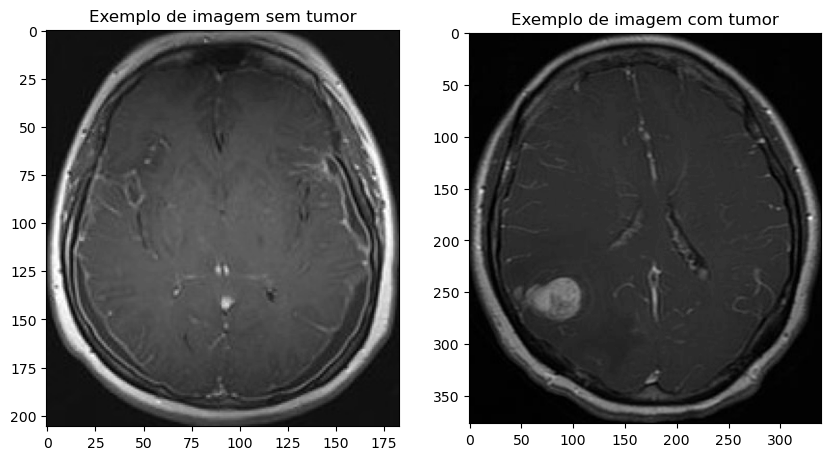

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(train_imgs_0[96], cmap='gray')
ax[0].set_title('Exemplo de imagem sem tumor')
ax[1].imshow(train_imgs_1[192], cmap='gray')
ax[1].set_title('Exemplo de imagem com tumor');

## 2. Segmentação

In [74]:
def kmeans_seg(img, k, cen='min'):
    kmeans = KMeans(n_clusters=k)
    img_train = img.reshape(-1, 1)
    result = kmeans.fit(img_train)
    
    labels = result.labels_
    cluster_centers = result.cluster_centers_
    
    cluster_centers = cluster_centers.reshape(1, -1)
    cluster_centers = list(cluster_centers[0])
    
    index_min = cluster_centers.index(min(cluster_centers))
    index_max = cluster_centers.index(max(cluster_centers))

    if cen == 'min':
        labels = (labels != index_min)
    elif cen == 'max':
        labels = (labels != index_max)
    
    img_final = labels.reshape(img.shape)
    
    return img_final.astype(np.uint8)


In [75]:
def segmentation(images):
    
    imgs_blur = [filters.gaussian(img, sigma=4) for img in images]
    k_seg = [kmeans_seg(img, 3) for img in imgs_blur]
    imgs_seg = [images[i] * k_seg[i] for i in range(len(images))]

    return imgs_seg


In [76]:
train_imgs_0 = segmentation(train_imgs_0)
train_imgs_1 = segmentation(train_imgs_1)

In [77]:
test_imgs_0 = segmentation(test_imgs_0)
test_imgs_1 = segmentation(test_imgs_1)

## Descritores de características

### GLCM

In [78]:
def glcm_extract_features(images, distance):
    
    features = np.zeros((len(images), 6))

    for i, img in enumerate(images):
        matrix0 = greycomatrix(img, [distance], [0], normed=True)
        matrix1 = greycomatrix(img, [distance], [np.pi/4], normed=True)
        matrix2 = greycomatrix(img, [distance], [np.pi/2], normed=True)
        matrix3 = greycomatrix(img, [distance], [3*np.pi/4], normed=True)
        matrix = (matrix0+matrix1+matrix2+matrix3)/4

        props = np.zeros(6)
        props[0] = greycoprops(matrix,'contrast')
        props[1] = greycoprops(matrix,'dissimilarity')
        props[2] = greycoprops(matrix,'homogeneity')
        props[3] = greycoprops(matrix,'energy')
        props[4] = greycoprops(matrix,'correlation')
        props[5] = greycoprops(matrix,'ASM')
        features[i] = props
    
    return features



In [82]:
features_test_0 = glcm_extract_features(test_imgs_0, 5);


c:\Users\Mateus\anaconda3\envs\tevc\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
c:\Users\Mateus\anaconda3\envs\tevc\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
c:\Users\Mateus\anaconda3\envs\tevc\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
c:\Users\Mateus\anaconda3\envs\tevc\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed

In [80]:
labels_test_0 = np.zeros(len(test_imgs_0))

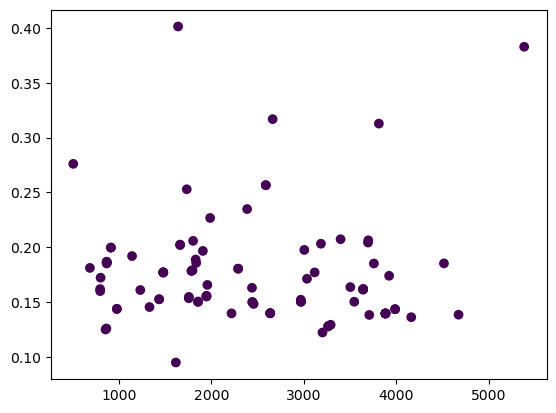

In [81]:
plt.scatter(features_test_0[:,0],features_test_0[:,3], c=labels_test_0)

# Testes

In [179]:
images_ti = intensity_transformation(images, 'po')

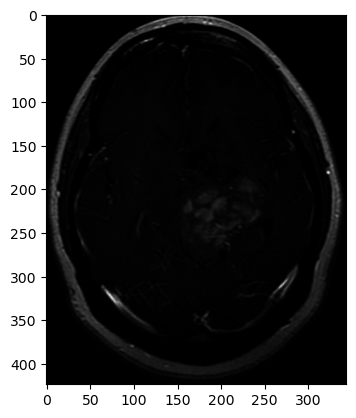

In [180]:
plt.imshow(images_ti[0], cmap='gray')

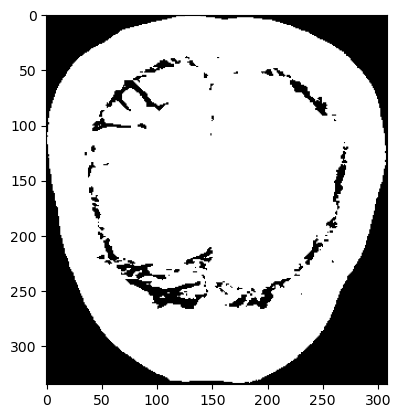

In [182]:
km = kmeans_seg(images[144], 3)

plt.imshow(km, cmap='gray')

In [164]:
gau_imgs = [filters.gaussian(img, sigma=1.5) for img in images]


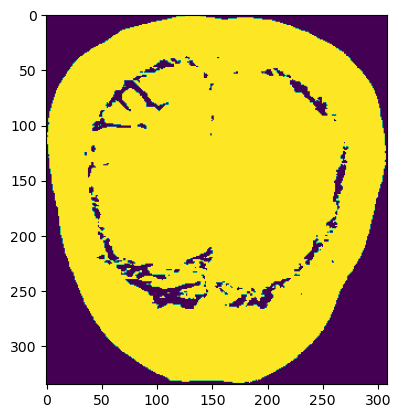

In [169]:
gau = kmeans_seg(images[144], 3)

plt.imshow(gau)

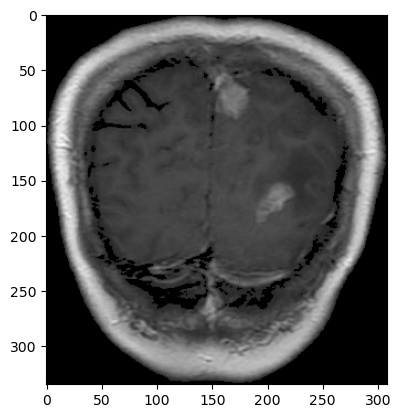

In [172]:
i = images[144] * gau.astype(np.uint8)

plt.imshow(i, cmap='gray')

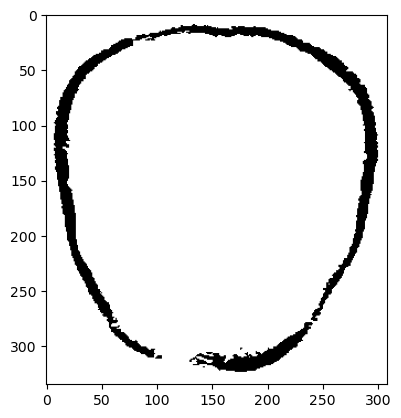

In [173]:
kmeans = KMeans(n_clusters=5)
img_train = i.reshape(-1, 1)
result = kmeans.fit(img_train)
    
labels = result.labels_
cluster_centers = result.cluster_centers_
    
cluster_centers = cluster_centers.reshape(1, -1)
cluster_centers = list(cluster_centers[0])
    
index_min = cluster_centers.index(min(cluster_centers))
index_max = cluster_centers.index(max(cluster_centers))

#print(labels)
#labels = ((labels != index_min) & (labels != index_max)).astype(np.uint8) * 225
labels = (labels != index_max)
img_final = labels.reshape(i.shape)

plt.imshow(img_final, cmap='gray')

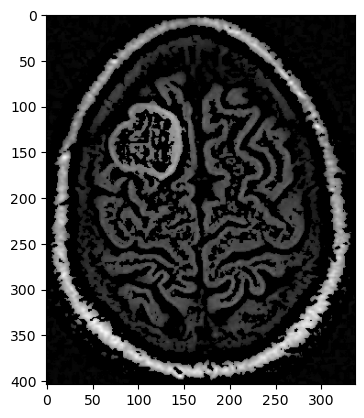

In [32]:
img_seg = images[0] * thres_local.astype(np.uint8)
plt.imshow(img_seg, cmap='gray')

<function matplotlib.pyplot.show(close=None, block=None)>

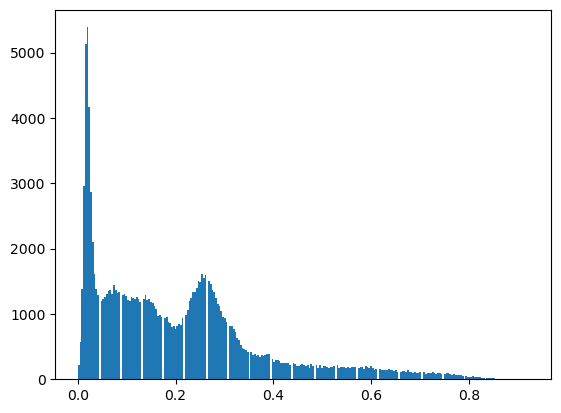

In [73]:
hist, tons = histogram(images[0])

plt.hist(images[0].ravel(), bins=256)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

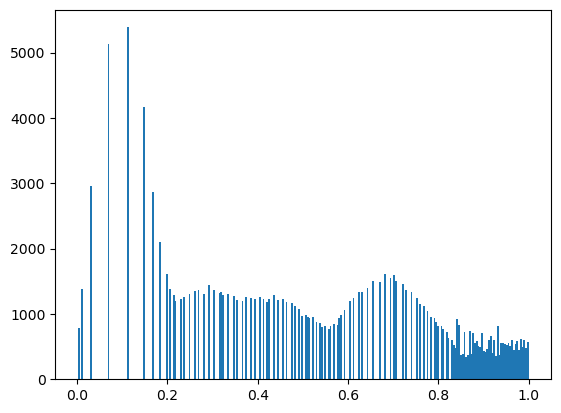

In [72]:
img_eq = equalize_hist(images[0])
plt.hist(img_eq.ravel(), bins=256)
plt.show

In [74]:
print(tons)

[0.00179994 0.00539982 0.00899969 0.01259957 0.01619945 0.01979933
 0.0233992  0.02699908 0.03059896 0.03419884 0.03779871 0.04139859
 0.04499847 0.04859835 0.05219822 0.0557981  0.05939798 0.06299786
 0.06659773 0.07019761 0.07379749 0.07739737 0.08099724 0.08459712
 0.088197   0.09179688 0.09539675 0.09899663 0.10259651 0.10619638
 0.10979626 0.11339614 0.11699602 0.12059589 0.12419577 0.12779565
 0.13139553 0.1349954  0.13859528 0.14219516 0.14579504 0.14939491
 0.15299479 0.15659467 0.16019455 0.16379442 0.1673943  0.17099418
 0.17459406 0.17819393 0.18179381 0.18539369 0.18899357 0.19259344
 0.19619332 0.1997932  0.20339308 0.20699295 0.21059283 0.21419271
 0.21779259 0.22139246 0.22499234 0.22859222 0.2321921  0.23579197
 0.23939185 0.24299173 0.24659161 0.25019148 0.25379136 0.25739124
 0.26099112 0.26459099 0.26819087 0.27179075 0.27539062 0.2789905
 0.28259038 0.28619026 0.28979013 0.29339001 0.29698989 0.30058977
 0.30418964 0.30778952 0.3113894  0.31498928 0.31858915 0.32218

In [75]:
im = images[0] * 255

In [76]:
im

array([[3., 2., 1., ..., 6., 6., 5.],
       [3., 2., 1., ..., 6., 6., 5.],
       [2., 2., 1., ..., 6., 6., 5.],
       ...,
       [3., 2., 2., ..., 5., 4., 4.],
       [3., 3., 2., ..., 5., 5., 5.],
       [3., 3., 3., ..., 6., 5., 6.]])

<function matplotlib.pyplot.show(close=None, block=None)>

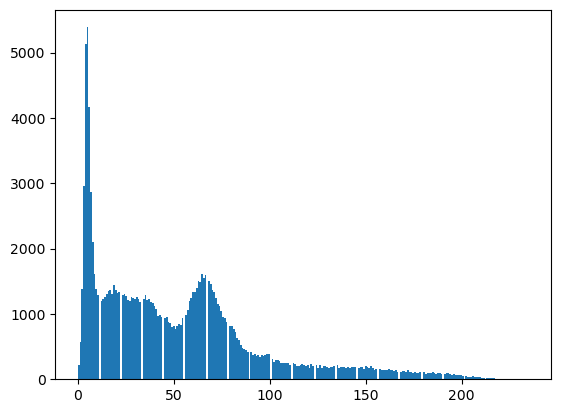

In [77]:
plt.hist(im.ravel(), bins=256)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

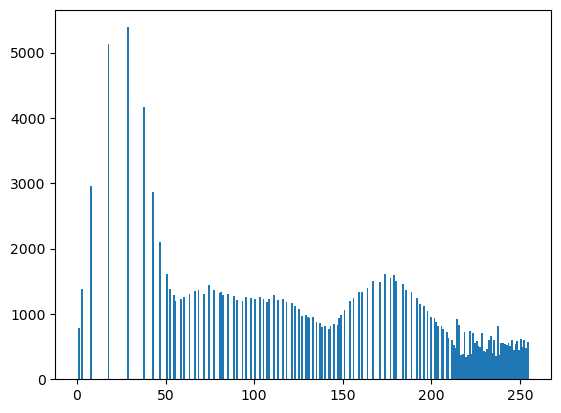

In [79]:
im_eq = equalize_hist(im)
plt.hist(im_eq.ravel() * 255, bins=256)
plt.show

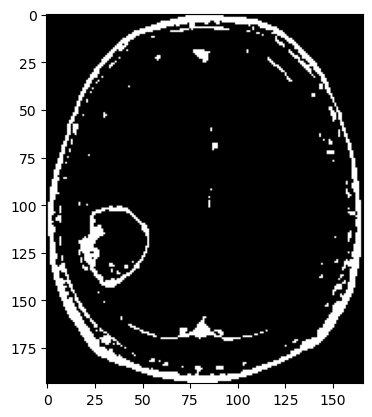

In [101]:
thres = (images[50] * 255) < 140 
plt.imshow(thres, cmap='binary')

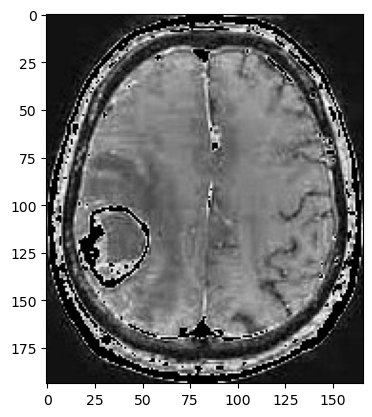

In [102]:
plt.imshow(images[50] * thres.astype(np.uint8), cmap='gray')